In [11]:
import palantir
import scanpy as sc
import pandas as pd
import os

# Plotting
import matplotlib
import matplotlib.pyplot as plt

# warnings
import warnings
from numba.core.errors import NumbaDeprecationWarning

warnings.filterwarnings(action="ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings(
    action="ignore", module="scanpy", message="No data for colormapping"
)

# Inline plotting
%matplotlib inline

In [12]:
# Load sample data
data_dir = os.path.expanduser("./")
download_url = "https://dp-lab-data-public.s3.amazonaws.com/palantir/marrow_sample_scseq_counts.h5ad"
file_path = os.path.join(data_dir, "marrow_sample_scseq_counts.h5ad")
ad = sc.read(file_path, backup_url=download_url)
ad



AnnData object with n_obs × n_vars = 4142 × 16106

In [49]:
ad

AnnData object with n_obs × n_vars = 4142 × 16106
    obs: 'n_counts', 'palantir_pseudotime', 'palantir_entropy'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_trends_clusters'
    uns: 'hvg', 'pca', 'DM_EigenValues', 'neighbors', 'umap', 'palantir_waypoints'
    obsm: 'X_pca', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'X_umap', 'palantir_fate_probabilities', 'branch_masks'
    varm: 'PCs', 'gene_trends_Ery', 'gene_trends_DC', 'gene_trends_Mono'
    layers: 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'DM_Similarity', 'distances', 'connectivities'

In [13]:
sc.pp.normalize_per_cell(ad)

In [14]:
palantir.preprocess.log_transform(ad)

In [15]:
#highly variable gene selection

sc.pp.highly_variable_genes(ad, n_top_genes=1500, flavor="cell_ranger")

In [16]:
# Note in the manuscript, we did not use highly variable genes but scanpy by default uses only highly variable genes
sc.pp.pca(ad)

In [17]:
ad

AnnData object with n_obs × n_vars = 4142 × 16106
    obs: 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [18]:
# run diffusion maps
dm_res = palantir.utils.run_diffusion_maps(ad, n_components=5)

Determing nearest neighbor graph...


In [19]:
ms_data = palantir.utils.determine_multiscale_space(ad)

## Visualisation

In [22]:
sc.pp.neighbors(ad)
sc.tl.umap(ad)

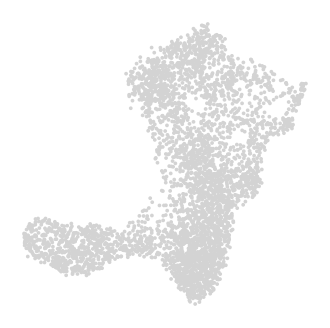

In [23]:
# use scanpy functions to visualise umaps or FDL

sc.pl.embedding(
    ad,
    basis="umap",
    frameon=False
)

MAGIC Imputation

In [25]:
imputed_X = palantir.utils.run_magic_imputation(ad)

`genes` paramter is an string iterable of genes, which are a subset of the expression of column names.
The below function plots the expression of the HSC gene `CD34`, myeloid gene `MPO`, erythroid precursor gene `GATA1`, dendritic cell gene `IRF8`.

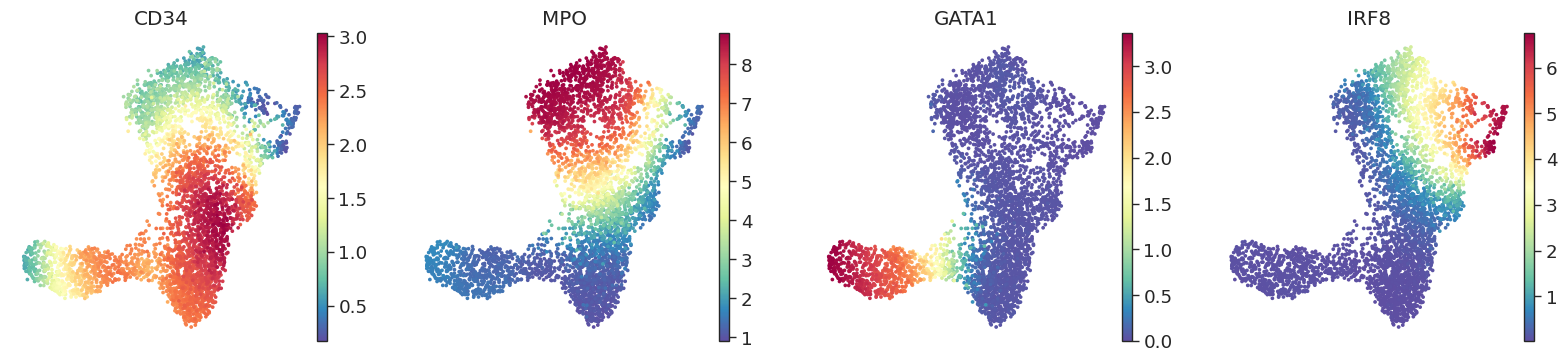

In [26]:
sc.pl.embedding(
    ad,
    basis="umap",
    layer="MAGIC_imputed_data",
    color=["CD34", "MPO", "GATA1", "IRF8"],
    frameon=False
)

plt.show()

Diffusion maps visualisation

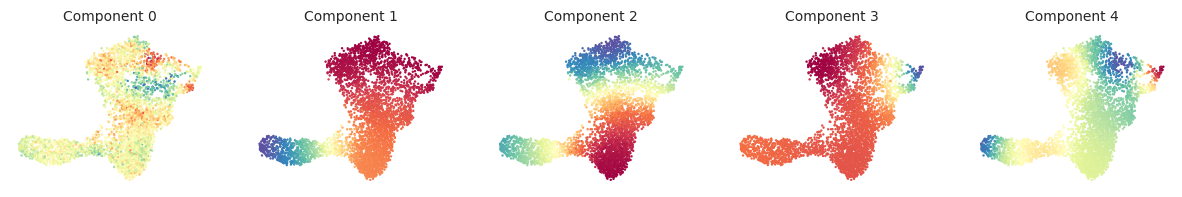

In [27]:
palantir.plot.plot_diffusion_components(ad)
plt.show()

Running Palantir

In [29]:
terminal_states = pd.Series(
    ["DC", "Mono", "Ery"],
    index=["Run5_131097901611291", "Run5_134936662236454", "Run4_200562869397916"],
)

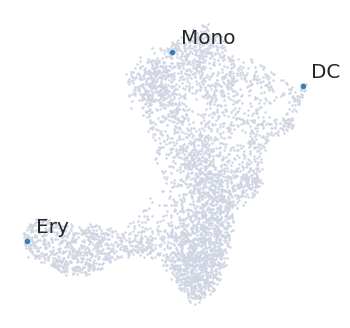

In [30]:
palantir.plot.highlight_cells_on_umap(ad, terminal_states)
plt.show()

Palantir generates the following results:
1. Pseudotime: Pseudo time ordering of each cell
2. Terminal state probabilities: Matrix of cells X terminal states. Each entry represents the probability of the corresponding cell reaching the respective terminal state
3. Entropy: A quantiative measure of the differentiation potential of each cell computed as the entropy of the multinomial terminal state probabilities

In [31]:
start_cell = "Run5_164698952452459"
pr_res = palantir.core.run_palantir(
    ad, start_cell, num_waypoints=500, terminal_states=terminal_states
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.005166931947072347 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.6880117694536845 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


Visualizing Palantir results

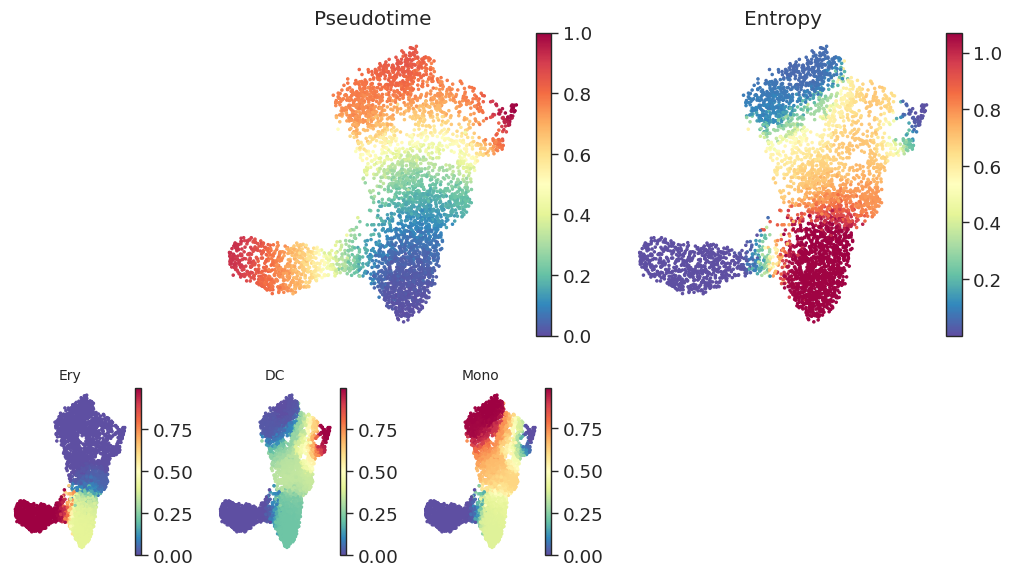

In [32]:
palantir.plot.plot_palantir_results(ad, s=3) # visualise Palantir results
plt.show()

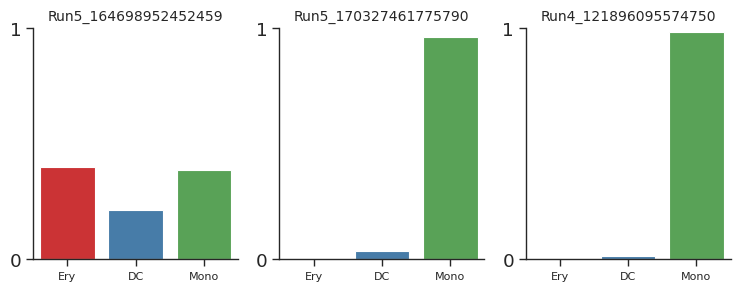

In [33]:
cells = [
    "Run5_164698952452459",
    "Run5_170327461775790",
    "Run4_121896095574750",
]
palantir.plot.plot_terminal_state_probs(ad, cells)
plt.show()

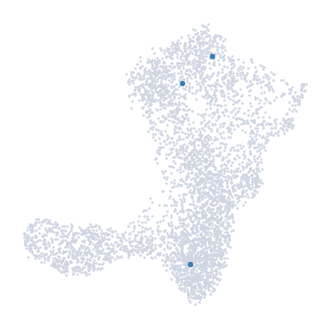

In [34]:
palantir.plot.highlight_cells_on_umap(ad, cells)
plt.show()

Gene Expression trends

Gene expression trends over pseudotime provide insights into the dynamic behavior of genes during cellular development or progression. By examining these trends, we can uncover the timing of gene expression changes and identify pivotal regulators of cellular states. Palantir provides tools for computing these gene expression trends.

We need to select cellss associated with a speicifc branch of the pseudotime trajectory.

In [37]:
masks = palantir.presults.select_branch_cells(ad, eps=0)

Visualising the branch selection

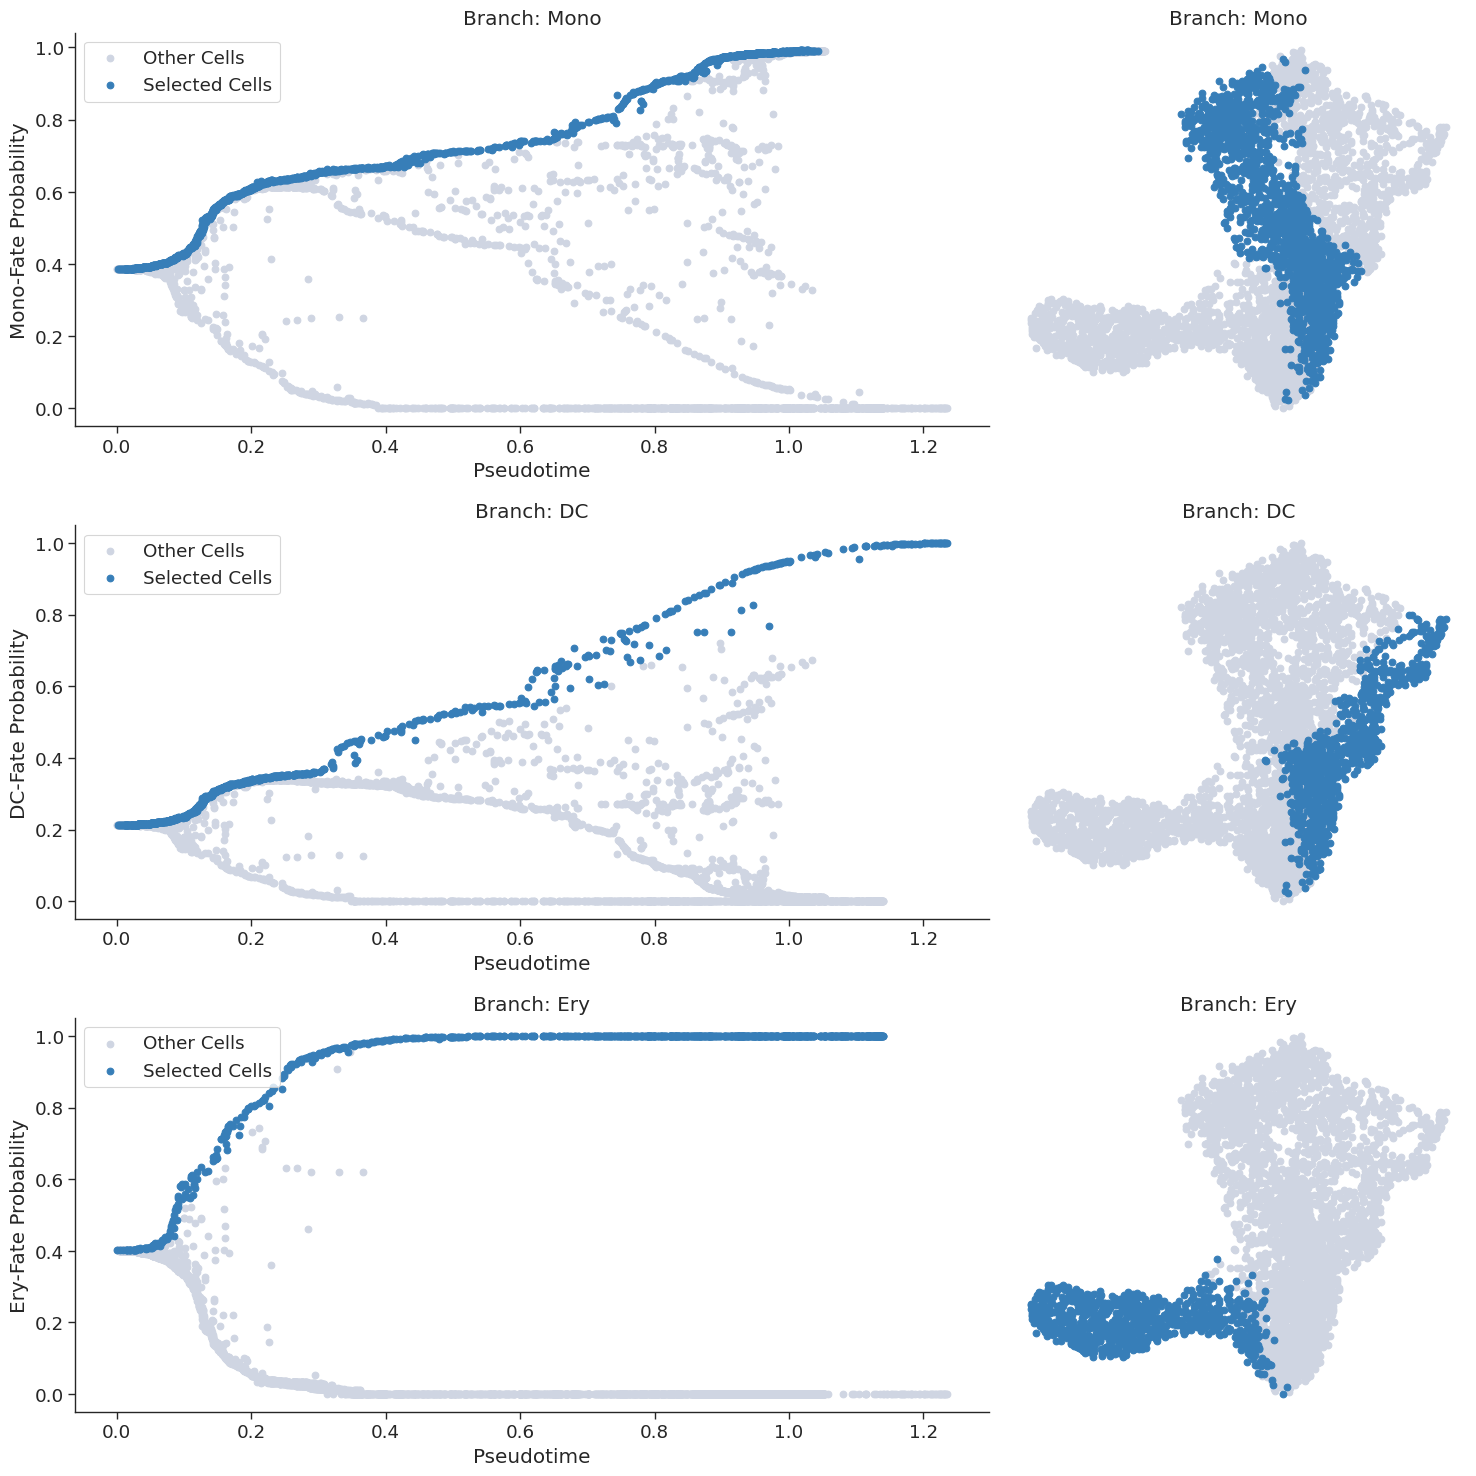

In [39]:
palantir.plot.plot_branch_selection(ad)
plt.show()

In [40]:
gene_trends = palantir.presults.compute_gene_trends(
    ad,
    expression_key="MAGIC_imputed_data"
)

Ery
[2023-10-06 12:45:01,991] [INFO    ] Using covariance function Matern52(ls=10.0).
DC
[2023-10-06 12:45:05,461] [INFO    ] Using covariance function Matern52(ls=10.0).
Mono
[2023-10-06 12:45:08,404] [INFO    ] Using covariance function Matern52(ls=10.0).


Palantir uses Mellon Function Estimator to determine the gene expression trends along different lineages. The marker trends can be determined using the `lineages` parameter.

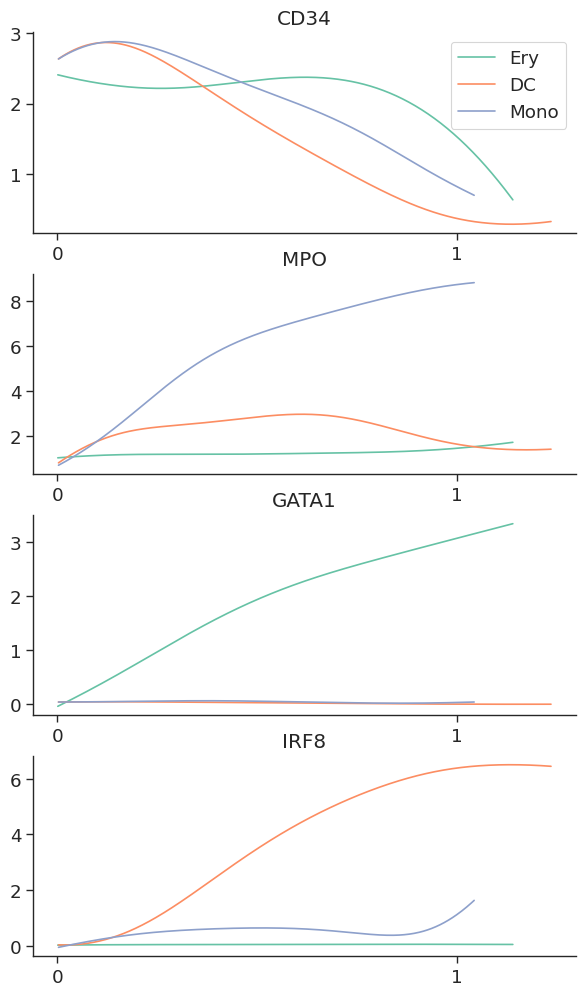

In [41]:
genes = ["CD34", "MPO", "GATA1", "IRF8"]
palantir.plot.plot_gene_trends(ad, genes)
plt.show()

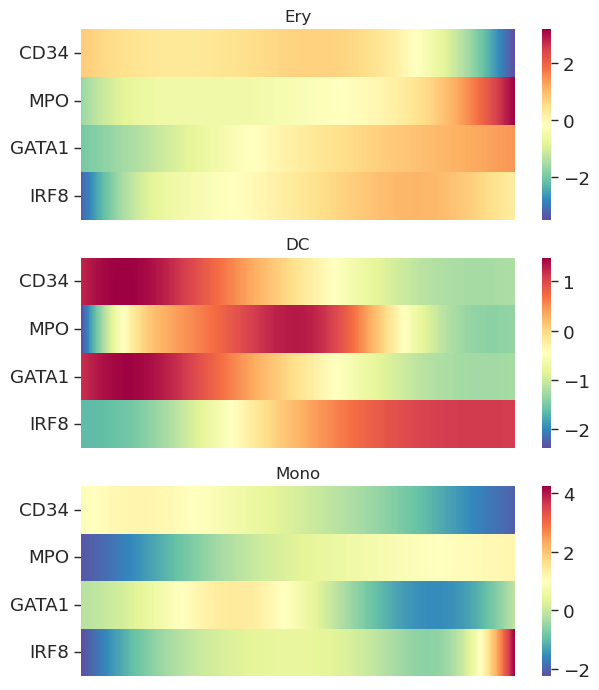

In [42]:
palantir.plot.plot_gene_trend_heatmaps(ad, genes)
plt.show()

Clustering

In [43]:
more_genes = ad.var_names[:1000]
communities = palantir.presults.cluster_gene_trends(ad, "Ery", more_genes)

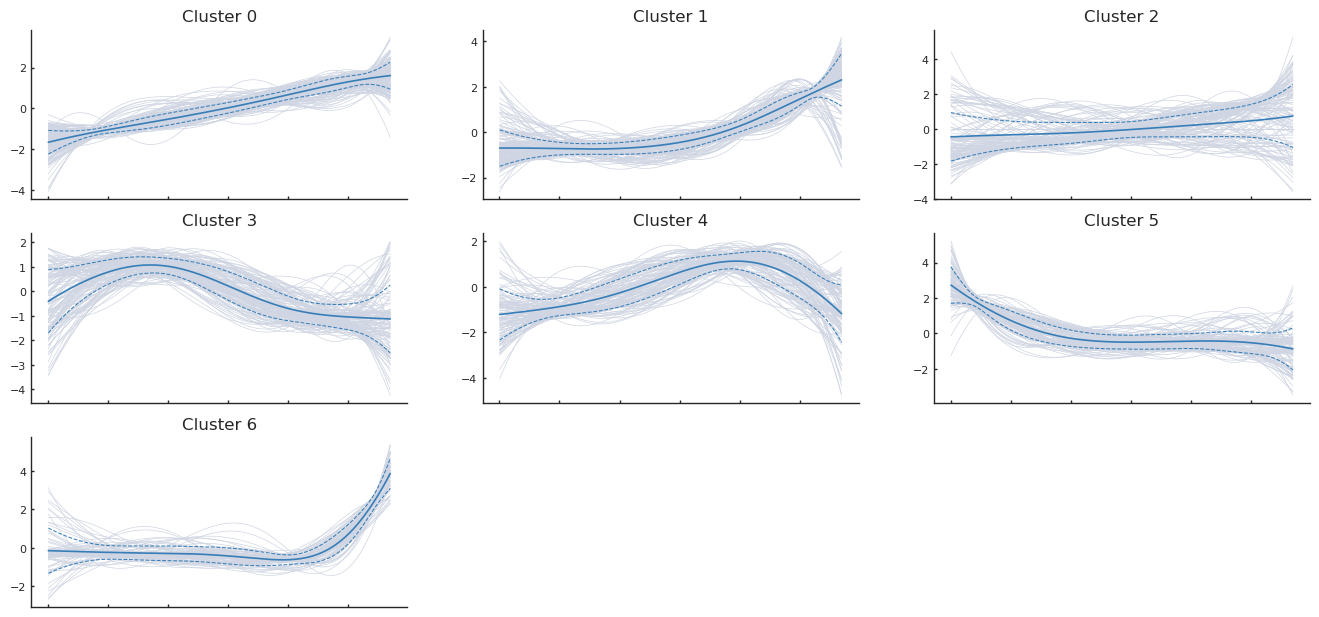

In [44]:
palantir.plot.plot_gene_trend_clusters(ad, "Ery")
plt.show()

Save Results

In [52]:
? ad.write



In [61]:
file_path = os.path.join(os.getcwd(), "marrow_sample_scseq_processed.h5ad")
file_path
ad.write(file_path)